In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from skimage import measure
from pydicom import dcmread
from scipy import interpolate
import matplotlib.pyplot as plt
from rt_utils import RTStructBuilder
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

abs_path = os.path.abspath("")

# Single Slice

## Inspect Metadata

In [2]:
path = "/Users/camillocaruso/LocalDocuments/Polmoni retrospettivi (125pz)/Immagini/TC_Adaptive/Adamo Gaetano/CT.1.3.12.2.1107.5.1.4.46530.30000012102906195490600000253.dcm"

metadata = dcmread( path )
metadata

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 166
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.12.2.1107.5.1.4.46530.30000012102906195490600000253
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.246.352.70.2.1.7
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 192'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL', 'CT_SOM5 SPI']
(0008, 0012) Instance Creation Date              DA: '20170621'
(0008, 0013) Instance Creation Time              TM: '110826.355000'
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.12.2.1107.5.1.4.465

## Anonymize dicom

Dicom files contain personal information about the patient and possibly also the physician, so it is necessary to anonymize this information to share the files.

In [3]:
print( metadata.PatientName )
print( metadata.PatientBirthDate )
print( metadata.ReferringPhysicianName )

ADAMO^GAETANO
19451002



In [4]:
def person_names_callback( dataset, data_element ):
    if data_element.VR == "PN":
        data_element.value = "anonymous"


def curves_callback( dataset, data_element ):
    if data_element.tag.group & 0xFF00 == 0x5000:
        del dataset[data_element.tag]
    
    
metadata.walk( person_names_callback )
metadata.walk( curves_callback )

metadata.remove_private_tags()
        
if 'OtherPatientIDs' in metadata:
    delattr( metadata, 'OtherPatientIDs' )

if 'OtherPatientIDsSequence' in metadata:
    del metadata.OtherPatientIDsSequence

tag = 'PatientBirthDate'
if tag in metadata:
    metadata.data_element( tag ).value = '19000101'

print( metadata.PatientName )
print( metadata.PatientBirthDate )
print( metadata.ReferringPhysicianName )

anonymous
19000101
anonymous


In [5]:
# save the anonymized file
save_path = os.path.join( abs_path, "anonymized_test_file.dcm" )
metadata.save_as( save_path )

## Visualize image

The image is located under the pixel_array attribute, but the value ranges may vary by machine.

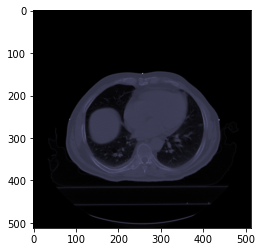

In [6]:
dtype = np.int16
image_raw = np.array( metadata.pixel_array, dtype=dtype )

plt.imshow( image_raw, cmap=plt.cm.bone )
plt.show()

### Rescale to Hounsfield Units

In order to transform the image to Hounsfield Units you need to apply the formula:
$$ CT_{hu} = ( CT * slope ) + intercept $$

In [7]:
slope = metadata.RescaleSlope
intercept = metadata.RescaleIntercept

print( slope )
print( intercept )

1
-1024


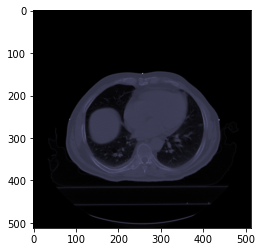

In [8]:
image_hu = ( image_raw * slope ) + intercept

plt.imshow( image_hu, cmap=plt.cm.bone )
plt.show()

Although the lower limit of the Hounsfield scale is -1000 (value indicating air) we can observe some pixels reaching lower values. These numbers are artificial and are inserted to fill in the spaces in order to make the image appear rectangular instead of circular.

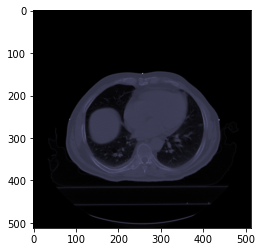

In [9]:
def set_padding_to_air( raw_pixelarrays ):
    raw_pixelarrays[ raw_pixelarrays < -1000 ] = -1000
    return raw_pixelarrays

image_hu = set_padding_to_air( image_hu )

plt.imshow( image_hu, cmap=plt.cm.bone )
plt.show()

### Interpolate image to unit pixel spacing

Looking at the metadata you can see the Pixel Spacing attribute, which indicates the distance in microns between the rows and columns, respectively. 
It is then possible to interpolate the images to obtain unit pixel spacing for all images.
When interpolating, however, attention must be paid to the position of the patient in the image.

In [10]:
r_spacing = metadata.PixelSpacing[0]
c_spacing = metadata.PixelSpacing[1]

print( r_spacing )
print( c_spacing )

9.765625e-1
9.765625e-1


In [11]:
x0, y0, z0 = metadata.ImagePositionPatient

print( x0 )
print( y0 )
print( z0 )

-250
-250
-6


In [12]:
nRows = metadata.Rows
nColumns = metadata.Columns

print( nRows )
print( nColumns )

512
512


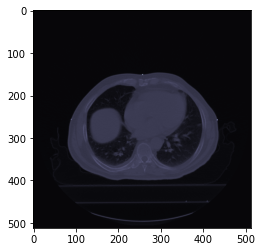

In [13]:
x = np.arange( 0, nRows * r_spacing, r_spacing )
y = np.arange( 0, nColumns * c_spacing, c_spacing )

x, y = x + (nRows/2 + x0), y + (nColumns/2 + y0)

# fill the value outside of the interpolating domain with -1000 which indicates air
f = interpolate.interp2d(x, y, image_hu, kind='cubic', fill_value=-1000)

new_r_spacing, new_c_spacing = 1, 1
xnew = np.arange( 0, nRows, new_r_spacing )
ynew = np.arange( 0, nColumns, new_c_spacing )
interpolated_image = f( xnew, ynew )

plt.imshow( interpolated_image, cmap=plt.cm.bone )
plt.show()

### Resize image

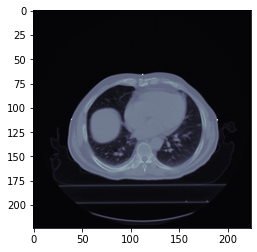

In [14]:
imagePIL = Image.fromarray( interpolated_image )

dim = 224
resize = (dim, dim)
image_resized = imagePIL.resize(resize)
image_resized = np.array( image_resized )

plt.imshow( image_resized, cmap=plt.cm.bone )
plt.show()

## RTStruct - Segmentation File

The segmentation file contains information about the ROIs contoured by the physician. 
By inspecting the metadata we can find information about the set of images the struct refers to, but we will see this later.

In [15]:
segmentation_path = "/Users/camillocaruso/LocalDocuments/Polmoni retrospettivi (125pz)/Immagini/TC_Adaptive/Adamo Gaetano/RS.Adamo Gaetano.dcm"

RTstruct_metadata = dcmread( segmentation_path )
RTstruct_metadata

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 170
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: RT Structure Set Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.246.352.205.5018653610294591360.5157257476651859080
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.246.352.70.2.1.7
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 192'
(0008, 0012) Instance Creation Date              DA: '20190117'
(0008, 0013) Instance Creation Time              TM: '192631.999000'
(0008, 0016) SOP Class UID                       UI: RT Structure Set Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.246.352.205.5018653610294591360.5157257476651859080
(0008, 0020) Study Date                          DA:

Using the RTStructBuilder function of the rt_utils library it is possible both to obtain the list of ROIs contained in the struct (useful to recognize the struct of interest in case more than one is present), and to reconstruct the entire volume of the mask of the chosen ROI.

In [16]:
directory_path = "/Users/camillocaruso/LocalDocuments/Polmoni retrospettivi (125pz)/Immagini/TC_Adaptive/Adamo Gaetano"

rtstruct = RTStructBuilder.create_from( dicom_series_path=directory_path, rt_struct_path=segmentation_path )    
roi_list = rtstruct.get_roi_names()
roi_list

['Body',
 'CTV',
 'Cuore',
 'Esofago',
 'Midollo spinale',
 'PTV',
 'Polmone dx',
 'Polmone sx',
 'Trachea e carena',
 'Polmoni-PTV',
 'GTV N',
 'GTV T']

In [17]:
ROI1 = "Polmone dx"
segmentation1 = rtstruct.get_roi_mask_by_name( ROI1 )

ROI2 = "Polmone sx"
segmentation2 = rtstruct.get_roi_mask_by_name( ROI2 )

mask_volume = np.logical_or( segmentation1, segmentation2 )

mask_volume = mask_volume.transpose(2,0,1)

mask_volume.shape

(124, 512, 512)

The images, unless they are reordered considering the entire volume of the patient as we will see later, appear in reverse order with respect to the mask.

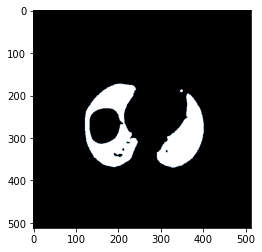

In [18]:
mask = np.array( mask_volume[ mask_volume.shape[0] - metadata.InstanceNumber ], dtype=dtype )

plt.imshow( mask, cmap=plt.cm.bone )
plt.show()

Since we have interpolated the image it is necessary to perform the same procedure also on the mask.

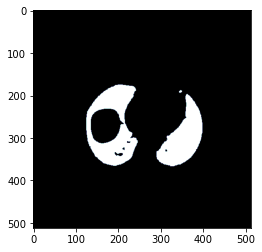

In [19]:
# In this case the fill_value is 0 to represent the non-lung area
f = interpolate.interp2d( x, y, mask, kind='cubic', fill_value=0 )
interpolated_mask = f( xnew, ynew ) > 0.5

plt.imshow( interpolated_mask, cmap=plt.cm.bone )
plt.show()

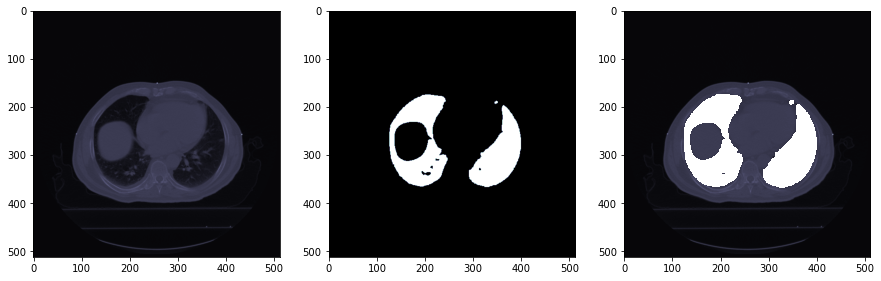

In [20]:
plt.figure( figsize=(15,7) )
plt.subplot(131)
plt.imshow( interpolated_image, cmap=plt.cm.bone )

plt.subplot(132)
plt.imshow( interpolated_mask, cmap=plt.cm.bone )

masked_image = np.ma.masked_where( interpolated_mask == True, interpolated_image )

plt.subplot(133)
plt.imshow( masked_image, cmap=plt.cm.bone )
plt.show()

To save the processed images we use the .tif format which allows us not to lose information.

In [21]:
image = Image.fromarray( interpolated_image )

image_save_path = os.path.join( abs_path, "tif_test_image.tif" )

image.save( image_save_path, 'TIFF' )

mask = Image.fromarray( interpolated_mask )

mask_save_path = os.path.join( abs_path, "tif_test_mask.tif" )

mask.save( mask_save_path, 'TIFF' )

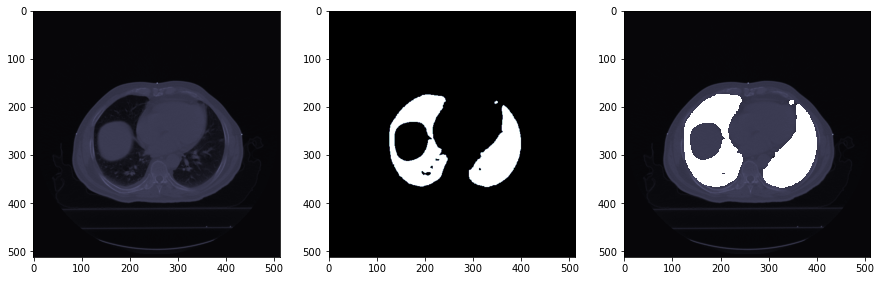

In [22]:
saved_image = Image.open( image_save_path )
saved_image = np.array( saved_image, dtype=dtype )

saved_mask = Image.open( mask_save_path )
saved_mask = np.array( saved_mask, dtype=dtype )

plt.figure( figsize=(15,7) )
plt.subplot(131)
plt.imshow( saved_image, cmap=plt.cm.bone )

plt.subplot(132)
plt.imshow( saved_mask, cmap=plt.cm.bone )

new_masked_image = np.ma.masked_where( saved_mask == True, saved_image )

plt.subplot(133)
plt.imshow( new_masked_image, cmap=plt.cm.bone )
plt.show()

# Entire patient

Let's start by collecting the list of file names related to the patient and their respective paths.

In [23]:
patient_path = "/Users/camillocaruso/LocalDocuments/Polmoni retrospettivi (125pz)/Immagini/TC_Adaptive/Adamo Gaetano"

slices_names = os.listdir( patient_path )
slices_names = [ slice_name for slice_name in slices_names if slice_name.endswith(".dcm") and not slice_name.startswith(".") ]

segmentation_name = "RS.Adamo Gaetano.dcm"

# Since the segmentation file in this case is located in the same folder as the images 
# you need to delete it from the list of names.
slices_names.remove( segmentation_name )

slices_paths = [ os.path.join( patient_path, slice_name ) for slice_name in slices_names ]

Now we get all metadata of the images and from them the names of the series they belong to, saved in the SeriesInstanceUID attribute.

In [24]:
slices = [ dcmread( slice_path ) for slice_path in slices_paths ]

series = [ slice_metadata.SeriesInstanceUID for slice_metadata in slices ]
series_numbers = pd.unique(series)
series_numbers

array(['1.3.12.2.1107.5.1.4.46530.30000012102906195490600000183'],
      dtype=object)

The series name to which the struct refers is instead inside some structures, saved with the same attribute.

In [25]:
struct_info = RTstruct_metadata.ReferencedFrameOfReferenceSequence[0]
struct_info = struct_info.RTReferencedStudySequence[0]
struct_info = struct_info.RTReferencedSeriesSequence[0]
struct_series = struct_info.SeriesInstanceUID
struct_series

'1.3.12.2.1107.5.1.4.46530.30000012102906195490600000183'

Let's now filter the slice information, keeping only those related to the series of interest.

In [26]:
slices = [ slice_metadata for i, slice_metadata in enumerate( slices ) if series[ i ] == struct_series ]

images = np.stack( [ file.pixel_array for file in slices ] )
images = images.astype( np.int16 )

When sorting the images, it is necessary to look at the attribute related to the position of the patient. 
However, unlike what we saw before, the coordinates are not always found in the correct order, i.e. (x,y,z). 
To find out which one is the z, simply look at which of the 3 coordinates has a number of different values equal to the number of coordinates present. 
In fact theoretically the patient's x and y coordinates should always remain the same or at least not vary much.

In [27]:
coordinates = pd.DataFrame( [ slice_metadata.ImagePositionPatient for slice_metadata in slices ] )
    
bool_z_coord = list( coordinates.apply(lambda col: True if col.nunique() == len(col) else False, axis=0).values )

if not any( bool_z_coord ):
    index_z_coord = 2
else:
    index_z_coord = int( bool_z_coord.index(True) )

new_index = coordinates.reset_index().sort_values(by=index_z_coord).loc[:, "index"].astype(int).values

slices = [ slices[index] for index in new_index ]
images = np.stack( [ images[index] for index in new_index] )
images = images.astype( np.int16 )

The coordinates, besides not being in the correct order, are often not suitable for image interpolation, since they lead to a translation towards the sides of the image. 
However, by observing the coordinates we can see that the x and y coordinates are never too far from each other. 
If the two coordinates left over from the exclusion of z are further than 0.1 from each other, we will assign to y the value of x. 

In [28]:
for n in range( len( slices ) ):
        
    intercept = slices[n].RescaleIntercept
    slope = slices[n].RescaleSlope

    if slope != 1:
        images[ n ] = slope * images[ n ].astype( np.float64 )
        images[ n ] = images[ n ].astype( np.int16 )

    images[ n ] += np.int16( intercept )
    
    x = np.arange( 0, slices[n].Rows * slices[n].PixelSpacing[0], slices[n].PixelSpacing[0] )
    y = np.arange( 0, slices[n].Columns * slices[n].PixelSpacing[1], slices[n].PixelSpacing[1] )
    
    image_coords = slices[n].ImagePositionPatient
    del image_coords[ index_z_coord ]

    x0, y0 = image_coords[0], image_coords[1]

    if abs(x0 - y0) > 1e-1:
        y0 = x0  
                 
    x, y = x + (slices[n].Rows/2 + x0), y + (slices[n].Columns/2 + y0)

    f = interpolate.interp2d(x, y, images[ n ] , kind='cubic', fill_value=-1000)
    images[ n ]  = f(xnew, ynew)
    
    f = interpolate.interp2d(x, y, mask_volume[ n ], kind='cubic', fill_value=0)
    mask_volume[ n ] = f(xnew, ynew) > 0.5
            
images = set_padding_to_air( images )

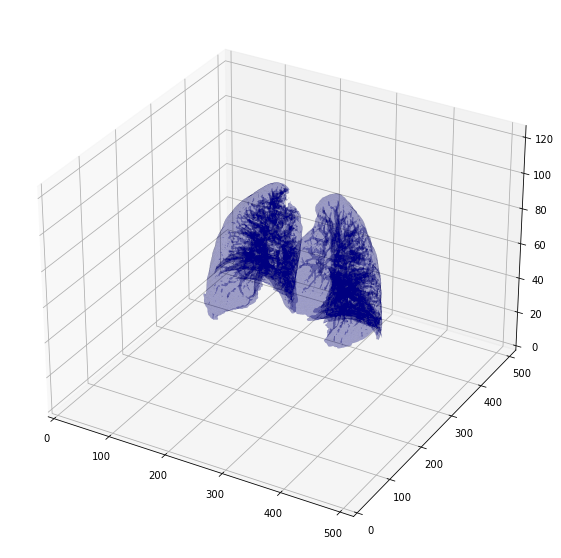

In [29]:
def plot_3d(image, threshold=-600, color="navy"):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    
    verts, faces, _, _ = measure.marching_cubes( p, threshold )

    fig = plt.figure( figsize=(10, 10) )
    ax = plt.axes( projection='3d' ) 
    fig.add_axes( ax )
    
    mesh = Poly3DCollection( verts[ faces ], alpha=0.2 )
    mesh.set_facecolor( color )
    ax.add_collection3d( mesh )

    ax.set_xlim( 0, p.shape[0] )
    ax.set_ylim( 0, p.shape[1] )
    ax.set_zlim( 0, p.shape[2] )

    plt.show()

plot_3d( images * mask_volume )